This notebook runs analysis on the ensemble forecasts created in the previous notebook. 

In [1]:
import pandas as pd
import glob
import os
import datetime
# import pvlib
from pv_model import model_pv_power
from forecast_solar import get_solar_forecast_fast
import matplotlib.pyplot as plt
# import scipy
import numpy as np

Read in specs that were processed and aggregated in the last notebook

In [2]:
folder = 'output_specs' 
filename = 'agg_specs_orig_df.pkl'
file_to_read = os.path.join(folder, filename)
agg_specs_orig_df = pd.read_pickle(file_to_read)
agg_specs_orig_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
latitude,32.811041,31.719983,33.021601,31.888,31.255,33.404486,30.4214,28.883196,31.435932,31.030996,32.104125,33.467803,32.4744,32.460054,32.533273,34.380532,26.090103,33.261505,29.271667,29.242304
longitude,-99.91749,-104.442292,-99.61463,-100.825,-102.272,-96.082472,-97.4614,-99.178605,-99.796613,-102.488209,-100.162375,-95.370856,-95.7156,-102.672809,-96.428985,-100.099625,-97.798453,-97.238057,-98.444722,-95.658144
nameplate_dc,131.5944,256.362179,94.507156,130.434783,234.0,170.854369,186.0,176.0,319.0,172.362353,143.08,260.0,82.098305,133.931,182.009816,165.306333,184.861111,191.275636,53.936118,162.4
nameplate_ac,100.8,188.2,74.9,100.0,180.0,125.7,144.0,132.4,250.0,126.3,102.2,198.5,59.8,100.7,147.6,121.4,137.5,148.8,39.2,120.0
mount_type,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis


In [3]:
num_plants = len(agg_specs_orig_df)
num_plants

20

Get a list of the timeseries files:

In [4]:
# timeseries data files
folder_ts = 'output_timeseries' 
filelist_ts = glob.glob(os.path.join(folder_ts, '*_actual_power_20240310-20250316.csv'))

Loop through plants and read in timeseries data:

In [5]:
agg_hsl = {}
agg_tel_net_out = {}

for plant_number in range(num_plants):
    # read in timeseries data from ERCOT
    ts_file = filelist_ts[plant_number]
    df_ts = pd.read_csv(ts_file,index_col=0,parse_dates=True,low_memory=False) #low_memory=False to avoid mixed variable type warning
    
    # outputs
    agg_hsl[plant_number] = df_ts['hsl']
    agg_tel_net_out[plant_number] = df_ts['telemetered_net_output']

# make dataframes 
agg_hsl_df = pd.concat(agg_hsl, axis=1)
agg_tel_net_out_df = pd.concat(agg_tel_net_out, axis=1)

In [6]:
thresh = 0.02 # fraction of peak power to set the curtailment threshold at
power_obs = agg_tel_net_out_df.resample('1h').mean()
hsl = agg_hsl_df.resample('1h').mean()
power_max_obs = power_obs.max()
curtailment = hsl - power_obs
curtailment_filter = curtailment > (thresh * power_max_obs)
# curtailment.iloc[:,0].plot()

In [7]:
power_obs[curtailment_filter] = np.nan

Let's import our ensemble forecast power data:

In [8]:
# power_fcasts_ens_all = pd.read_csv('forecasts/power_fcasts_ens_all.csv', parse_dates=['valid_time', 'init_time'], index_col='valid_time')
power_fcasts_ens_all_unstacked = pd.read_pickle('forecasts/power_fcasts_ens_all_unstacked.pkl')
power_fcasts_ens_all_unstacked

power                                          \
member                             1    2    3    4    5    6    7    8    9    
valid_time                point                                                 
2024-03-11 12:30:00+00:00 0       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                          1       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                          2       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                          3       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                          4       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                               ...  ...  ...  ...  ...  ...  ...  ...  ...   
2025-03-10 11:30:00+00:00 15      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                          16      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                          17      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                          18      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                          19      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                      ...                                     \
member                            10  ...   41   42   43   44   45   46   47   
valid_time                point       ...                                      
2024-03-11 12:30:00+00:00 0      0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                          1      0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                          2      0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                          3      0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                          4      0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                              ...  ...  ...  ...  ...  ...  ...  ...  ...   
2025-03-10 11:30:00+00:00 15     0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                          16     0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                          17     0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                          18     0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                          19     0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                                
member                            48   49   50  
valid_time                point                 
2024-03-11 12:30:00+00:00 0      0.0  0.0  0.0  
                          1      0.0  0.0  0.0  
                          2      0.0  0.0  0.0  
                          3      0.0  0.0  0.0  
                          4      0.0  0.0  0.0  
...                              ...  ...  ...  
2025-03-10 11:30:00+00:00 15     0.0  0.0  0.0  
                          16     0.0  0.0  0.0  
                          17     0.0  0.0  0.0  
                          18     0.0  0.0  0.0  
                          19     0.0  0.0  0.0  

[174480 rows x 50 columns]

In [9]:
power_fcasts_ens_all = power_fcasts_ens_all_unstacked.stack(future_stack=True).reset_index().set_index('valid_time')

In [10]:
# adjust timestamps to beginning of interval to match observations
power_fcasts_ens_all.index = power_fcasts_ens_all.index - pd.Timedelta('30min')

In [11]:
power_fcasts_ens_all.head()

,point,member,power
valid_time,,,
2024-03-11 12:00:00+00:00,0,1,0.0
2024-03-11 12:00:00+00:00,0,2,0.0
2024-03-11 12:00:00+00:00,0,3,0.0
2024-03-11 12:00:00+00:00,0,4,0.0
2024-03-11 12:00:00+00:00,0,5,0.0


In [12]:
power_obs_all = (hsl
                 .stack(future_stack=True)
                 .to_frame()
                 .reset_index()
                 .rename(columns={'interval_start_utc': 'valid_time',
                                  'level_1': 'point',
                                  0: 'power_obs'})
                 .set_index(['valid_time']))

# convert to central time
power_fcasts_ens_all.index = power_fcasts_ens_all.index.tz_convert('Etc/GMT+5')
power_obs_all.index = power_obs_all.index.tz_convert('Etc/GMT+5')

power_obs_all

,point,power_obs
valid_time,,
2024-03-10 07:00:00-05:00,0,0.0
2024-03-10 07:00:00-05:00,1,0.0
2024-03-10 07:00:00-05:00,2,0.0
2024-03-10 07:00:00-05:00,3,0.0
2024-03-10 07:00:00-05:00,4,0.0
...,...,...
2025-03-16 06:00:00-05:00,15,0.0
2025-03-16 06:00:00-05:00,16,0.0
2025-03-16 06:00:00-05:00,17,0.0


Now drop Plants 0, 5, and 9, as we did previously:

In [13]:
drop_list = [0, 5, 9]
power_obs_all = power_obs_all[~power_obs_all['point'].isin(drop_list)]
power_fcasts_ens_all = power_fcasts_ens_all[~power_fcasts_ens_all['point'].isin(drop_list)]
agg_specs_orig_df = agg_specs_orig_df.drop([0, 5, 9], axis=1)
num_plants = len(agg_specs_orig_df)

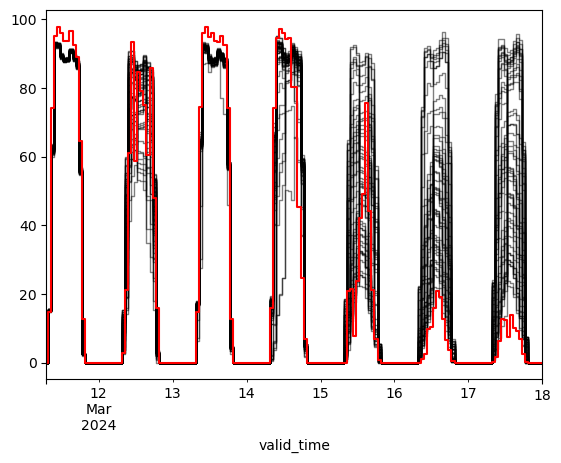

In [14]:
member_list = power_fcasts_ens_all['member'].unique()

startidx=0
endidx=162

for plant_number in [3]:
    for member in member_list:
        power_fcasts_ens_all[(power_fcasts_ens_all['member'] == member) & (power_fcasts_ens_all['point'] == plant_number)]['power'][startidx:endidx].plot(label=('ens mem ' + str(member)), drawstyle='steps-mid', color='k', linewidth=1, alpha=0.5)
    power_obs_all[power_obs_all['point'] == plant_number]['power_obs'][startidx+24:endidx+24].plot(label=('ens mem ' + str(member)), drawstyle='steps-mid', color='r', linewidth=1.5)

Add week number, then add `week`, `point`, and `member` as indices.

In [15]:
df = power_fcasts_ens_all.copy()

# add week as a column
day_one = df.index.get_level_values('valid_time').min().floor('1d')

df['week'] = np.floor((df.index.get_level_values('valid_time') - day_one).days / 7)


df = df.reset_index().set_index(['week', 'point', 'member', 'valid_time'])
df

power
week point member valid_time                      
0.0  1     1      2024-03-11 07:00:00-05:00    0.0
           2      2024-03-11 07:00:00-05:00    0.0
           3      2024-03-11 07:00:00-05:00    0.0
           4      2024-03-11 07:00:00-05:00    0.0
           5      2024-03-11 07:00:00-05:00    0.0
...                                            ...
52.0 19    46     2025-03-10 06:00:00-05:00    0.0
           47     2025-03-10 06:00:00-05:00    0.0
           48     2025-03-10 06:00:00-05:00    0.0
           49     2025-03-10 06:00:00-05:00    0.0
           50     2025-03-10 06:00:00-05:00    0.0

[7415400 rows x 1 columns]

Use `groupby` to sum daily energy for each point and member:

In [16]:
df = df.groupby([pd.Grouper(level='point'),
                 pd.Grouper(level='week'),
                 pd.Grouper(level='member'), 
                 pd.Grouper(level='valid_time', freq='1D')]
               ).sum()
df = df.rename(columns={'power': 'daily_energy'})
df

daily_energy
point week member valid_time                             
1     0.0  1      2024-03-11 00:00:00-05:00   1751.071949
                  2024-03-12 00:00:00-05:00   1784.435784
                  2024-03-13 00:00:00-05:00   1785.889312
                  2024-03-14 00:00:00-05:00   1576.609495
                  2024-03-15 00:00:00-05:00    729.300229
...                                                   ...
19    52.0 46     2025-03-10 00:00:00-05:00      0.000000
           47     2025-03-10 00:00:00-05:00      0.000000
           48     2025-03-10 00:00:00-05:00      0.000000
           49     2025-03-10 00:00:00-05:00      0.000000
           50     2025-03-10 00:00:00-05:00      0.000000

[310250 rows x 1 columns]

Then, for each day in the week, calculate the number of members for which that day had the lowest daily energy.

First, just to make testing easier, filter on point 1 and members 1-4:

In [17]:
df_temp = df[(df.index.get_level_values('point')==1) & (df.index.get_level_values('member')<5)]

Then, unstack across members:

In [18]:
df_temp = df_temp.unstack(level='member')
df_temp

daily_energy                            \
member                                          1            2            3   
point week valid_time                                                         
1     0.0  2024-03-11 00:00:00-05:00  1751.071949  1743.209984  1725.935609   
           2024-03-12 00:00:00-05:00  1784.435784  1770.259692  1781.856188   
           2024-03-13 00:00:00-05:00  1785.889312  1802.346782  1796.227741   
           2024-03-14 00:00:00-05:00  1576.609495  1723.354205  1799.751029   
           2024-03-15 00:00:00-05:00   729.300229   341.629637  1692.070202   
...                                           ...          ...          ...   
      51.0 2025-03-06 00:00:00-05:00  1615.676041   986.441811  1528.539993   
           2025-03-07 00:00:00-05:00  1337.782294  1731.979884  1725.565928   
           2025-03-08 00:00:00-05:00   714.217150  1748.202812  1211.823806   
           2025-03-09 00:00:00-05:00  1783.440859  1818.841510  1799.942398   
      52.0 2025-03-10 00:00:00-05:00     0.000000     0.000000     0.000000   

                                                   
member                                          4  
point week valid_time                              
1     0.0  2024-03-11 00:00:00-05:00  1764.765523  
           2024-03-12 00:00:00-05:00  1788.511929  
           2024-03-13 00:00:00-05:00  1793.538735  
           2024-03-14 00:00:00-05:00  1746.876695  
           2024-03-15 00:00:00-05:00   348.226026  
...                                           ...  
      51.0 2025-03-06 00:00:00-05:00  1423.293655  
           2025-03-07 00:00:00-05:00  1726.549761  
           2025-03-08 00:00:00-05:00  1472.762111  
           2025-03-09 00:00:00-05:00  1814.218928  
      52.0 2025-03-10 00:00:00-05:00     0.000000  

[365 rows x 4 columns]

We can group by point and week and find the minimum daily energy each week/point combination across members:

In [19]:
df_temp.groupby(level=['point','week']).min()

daily_energy                                       
member                1            2            3            4
point week                                                    
1     0.0    729.300229   341.629637  1516.558190   348.226026
      1.0    836.510795   806.785252   847.474674   862.162885
      2.0   1400.137089  1415.755002  1656.422958  1482.854675
      3.0   1439.877054  1204.944336  1525.644393  1273.850758
      4.0   1808.414484   521.379080  1549.738118   975.025107
      5.0   1190.643113   681.324044  1489.243190   426.054211
      6.0   1887.314760  1742.098853  1846.823252  1624.665341
      7.0    459.689144  1826.800846  1307.817611  1883.767747
      8.0    556.523286  1756.920720   535.557486  1493.233299
      9.0   1981.327652  1708.714935  2034.230881   967.727787
      10.0  1923.439491  1715.133419  1777.133020  1432.559327
      11.0  1770.702343  1946.786198  1033.630358  1530.361807
      12.0  2048.423608  1703.199984  1388.718359  1350.044771
      13.0  1138.167983  1180.334087  1015.551346  1093.519013
      14.0  1616.999119   745.001544   555.456290  1623.094262
      15.0  1654.675701  1547.476734   743.890660  1531.664167
      16.0  1917.049904  1574.076836  1613.498321  1524.302560
      17.0  1485.811355  1499.668079  1763.711579  1653.194553
      18.0  1647.426984  1157.735018  1722.985434  1332.755057
      19.0  1466.416726  1012.995637  1250.534224   904.743881
      20.0  1828.126903  1537.329810  1802.617024   629.133921
      21.0  1946.066084  1789.279320  1797.476070  1961.985100
      22.0  1695.095945  1707.117978  1827.609112  1602.706639
      23.0  1728.503272  1546.150157  1850.925635  1720.557926
      24.0  1183.204376  1027.749569  1437.795893  1620.856622
      25.0   580.677433   990.931609   569.046806   409.879706
      26.0  1623.218875  1738.538519  1597.136390  1581.026673
      27.0  1421.189856  1390.664756  1363.757765  1417.676179
      28.0  1478.296576  1518.428007   755.869085  1594.850961
      29.0  1583.250136  1645.905482  1636.482293  1646.932043
      30.0  1378.793287  1476.991143  1273.004283  1356.679311
      31.0   758.347770   857.660903  1058.316784  1132.172864
      32.0  1377.077481  1381.963332  1366.645394  1334.849052
      33.0  1213.559876   532.876136   825.078490   919.009596
      34.0  1143.124493  1180.636028   765.733248   168.379656
      35.0   565.314505   868.651285   876.649503   710.292265
      36.0   896.733567  1144.403700  1082.202326  1059.458950
      37.0   601.393800   151.492015   529.052711   344.809530
      38.0   173.620393   465.831023   507.553348   312.782165
      39.0   723.302743   523.669400   482.023751   783.944459
      40.0  1095.032557   718.973588  1056.037650   823.105853
      41.0   871.818532   994.833075   656.061353   819.352398
      42.0   903.484568   901.631631  1094.777106   921.321444
      43.0   588.840691   284.101845   267.032856   198.634020
      44.0   574.130628   640.199575   134.544349   357.476804
      45.0  1262.308677  1225.284620  1254.718926  1056.875447
      46.0   599.358844   961.757869   755.041413   816.313421
      47.0   827.622604  1057.641442  1160.785770  1309.136445
      48.0   717.015195   541.019538   571.789305   950.222288
      49.0  1462.291088   797.507281  1375.017147  1385.766122
      50.0  1051.735616  1194.006792  1071.972070  1256.857742
      51.0   714.217150   986.441811  1211.823806  1423.293655
      52.0     0.000000     0.000000     0.000000     0.000000

This sort-of gets the day with the minimum daily energy for each week/point combination across members:

In [20]:
df_temp.groupby(level=['point','week']).idxmin()

daily_energy  \
member                                         1   
point week                                         
1     0.0    (1, 0.0, 2024-03-15 00:00:00-05:00)   
      1.0    (1, 1.0, 2024-03-24 00:00:00-05:00)   
      2.0    (1, 2.0, 2024-03-30 00:00:00-05:00)   
      3.0    (1, 3.0, 2024-04-02 00:00:00-05:00)   
      4.0    (1, 4.0, 2024-04-09 00:00:00-05:00)   
      5.0    (1, 5.0, 2024-04-21 00:00:00-05:00)   
      6.0    (1, 6.0, 2024-04-24 00:00:00-05:00)   
      7.0    (1, 7.0, 2024-05-04 00:00:00-05:00)   
      8.0    (1, 8.0, 2024-05-10 00:00:00-05:00)   
      9.0    (1, 9.0, 2024-05-16 00:00:00-05:00)   
      10.0  (1, 10.0, 2024-05-21 00:00:00-05:00)   
      11.0  (1, 11.0, 2024-06-02 00:00:00-05:00)   
      12.0  (1, 12.0, 2024-06-06 00:00:00-05:00)   
      13.0  (1, 13.0, 2024-06-10 00:00:00-05:00)   
      14.0  (1, 14.0, 2024-06-21 00:00:00-05:00)   
      15.0  (1, 15.0, 2024-06-26 00:00:00-05:00)   
      16.0  (1, 16.0, 2024-07-07 00:00:00-05:00)   
      17.0  (1, 17.0, 2024-07-09 00:00:00-05:00)   
      18.0  (1, 18.0, 2024-07-21 00:00:00-05:00)   
      19.0  (1, 19.0, 2024-07-22 00:00:00-05:00)   
      20.0  (1, 20.0, 2024-08-02 00:00:00-05:00)   
      21.0  (1, 21.0, 2024-08-06 00:00:00-05:00)   
      22.0  (1, 22.0, 2024-08-15 00:00:00-05:00)   
      23.0  (1, 23.0, 2024-08-22 00:00:00-05:00)   
      24.0  (1, 24.0, 2024-08-31 00:00:00-05:00)   
      25.0  (1, 25.0, 2024-09-02 00:00:00-05:00)   
      26.0  (1, 26.0, 2024-09-15 00:00:00-05:00)   
      27.0  (1, 27.0, 2024-09-19 00:00:00-05:00)   
      28.0  (1, 28.0, 2024-09-27 00:00:00-05:00)   
      29.0  (1, 29.0, 2024-10-05 00:00:00-05:00)   
      30.0  (1, 30.0, 2024-10-12 00:00:00-05:00)   
      31.0  (1, 31.0, 2024-10-17 00:00:00-05:00)   
      32.0  (1, 32.0, 2024-10-27 00:00:00-05:00)   
      33.0  (1, 33.0, 2024-11-01 00:00:00-05:00)   
      34.0  (1, 34.0, 2024-11-04 00:00:00-05:00)   
      35.0  (1, 35.0, 2024-11-17 00:00:00-05:00)   
      36.0  (1, 36.0, 2024-11-24 00:00:00-05:00)   
      37.0  (1, 37.0, 2024-11-30 00:00:00-05:00)   
      38.0  (1, 38.0, 2024-12-05 00:00:00-05:00)   
      39.0  (1, 39.0, 2024-12-13 00:00:00-05:00)   
      40.0  (1, 40.0, 2024-12-18 00:00:00-05:00)   
      41.0  (1, 41.0, 2024-12-23 00:00:00-05:00)   
      42.0  (1, 42.0, 2025-01-04 00:00:00-05:00)   
      43.0  (1, 43.0, 2025-01-09 00:00:00-05:00)   
      44.0  (1, 44.0, 2025-01-16 00:00:00-05:00)   
      45.0  (1, 45.0, 2025-01-22 00:00:00-05:00)   
      46.0  (1, 46.0, 2025-01-28 00:00:00-05:00)   
      47.0  (1, 47.0, 2025-02-09 00:00:00-05:00)   
      48.0  (1, 48.0, 2025-02-10 00:00:00-05:00)   
      49.0  (1, 49.0, 2025-02-18 00:00:00-05:00)   
      50.0  (1, 50.0, 2025-02-26 00:00:00-05:00)   
      51.0  (1, 51.0, 2025-03-08 00:00:00-05:00)   
      52.0  (1, 52.0, 2025-03-10 00:00:00-05:00)   

                                                  \
member                                         2   
point week                                         
1     0.0    (1, 0.0, 2024-03-15 00:00:00-05:00)   
      1.0    (1, 1.0, 2024-03-18 00:00:00-05:00)   
      2.0    (1, 2.0, 2024-03-29 00:00:00-05:00)   
      3.0    (1, 3.0, 2024-04-02 00:00:00-05:00)   
      4.0    (1, 4.0, 2024-04-09 00:00:00-05:00)   
      5.0    (1, 5.0, 2024-04-21 00:00:00-05:00)   
      6.0    (1, 6.0, 2024-04-25 00:00:00-05:00)   
      7.0    (1, 7.0, 2024-05-05 00:00:00-05:00)   
      8.0    (1, 8.0, 2024-05-11 00:00:00-05:00)   
      9.0    (1, 9.0, 2024-05-18 00:00:00-05:00)   
      10.0  (1, 10.0, 2024-05-21 00:00:00-05:00)   
      11.0  (1, 11.0, 2024-06-01 00:00:00-05:00)   
      12.0  (1, 12.0, 2024-06-07 00:00:00-05:00)   
      13.0  (1, 13.0, 2024-06-10 00:00:00-05:00)   
      14.0  (1, 14.0, 2024-06-21 00:00:00-05:00)   
      15.0  (1, 15.0, 2024-06-25 00:00:00-05:00)   
      16.0  (1, 16.0, 2024-07-03 00:00:00-05:00)   
      17.0  (1, 17.0, 2024-07-09 00:00:00-05:00)   
      18.0  (1, 18.0, 2024-07-2

We can stack that

In [21]:
df_temp.groupby(level=['point','week']).idxmin().stack(future_stack=True)

daily_energy
point week member                                      
1     0.0  1        (1, 0.0, 2024-03-15 00:00:00-05:00)
           2        (1, 0.0, 2024-03-15 00:00:00-05:00)
           3        (1, 0.0, 2024-03-17 00:00:00-05:00)
           4        (1, 0.0, 2024-03-15 00:00:00-05:00)
      1.0  1        (1, 1.0, 2024-03-24 00:00:00-05:00)
...                                                 ...
      51.0 4       (1, 51.0, 2025-03-06 00:00:00-05:00)
      52.0 1       (1, 52.0, 2025-03-10 00:00:00-05:00)
           2       (1, 52.0, 2025-03-10 00:00:00-05:00)
           3       (1, 52.0, 2025-03-10 00:00:00-05:00)
           4       (1, 52.0, 2025-03-10 00:00:00-05:00)

[212 rows x 1 columns]

In [22]:
df_new = (df
          .unstack(level='member')
          .groupby(level=['point','week'])
          .idxmin()
          .stack(future_stack=True)
          .reset_index())

df_new = pd.DataFrame(list(df_new['daily_energy']),
         columns=['point', 'week', 'lowest_energy_day'])



Then reset the index:

In [23]:
df_temp2 = df_temp.groupby(level=['point','week']).idxmin().stack(future_stack=True).reset_index()
df_temp2

,point,week,member,daily_energy
0,1,0.0,1,"(1, 0.0, 2024-03-15 00:00:00-05:00)"
1,1,0.0,2,"(1, 0.0, 2024-03-15 00:00:00-05:00)"
2,1,0.0,3,"(1, 0.0, 2024-03-17 00:00:00-05:00)"
3,1,0.0,4,"(1, 0.0, 2024-03-15 00:00:00-05:00)"
4,1,1.0,1,"(1, 1.0, 2024-03-24 00:00:00-05:00)"
...,...,...,...,...
207,1,51.0,4,"(1, 51.0, 2025-03-06 00:00:00-05:00)"
208,1,52.0,1,"(1, 52.0, 2025-03-10 00:00:00-05:00)"
209,1,52.0,2,"(1, 52.0, 2025-03-10 00:00:00-05:00)"
210,1,52.0,3,"(1, 52.0, 2025-03-10 00:00:00-05:00)"


The `daily_energy` column is a list of tuples, containing point, member, and day (with minimum energy). We can simply extract that column and turn it into a dataframe:

In [24]:
df_temp2['daily_energy']

0       (1, 0.0, 2024-03-15 00:00:00-05:00)
1       (1, 0.0, 2024-03-15 00:00:00-05:00)
2       (1, 0.0, 2024-03-17 00:00:00-05:00)
3       (1, 0.0, 2024-03-15 00:00:00-05:00)
4       (1, 1.0, 2024-03-24 00:00:00-05:00)
                       ...                 
207    (1, 51.0, 2025-03-06 00:00:00-05:00)
208    (1, 52.0, 2025-03-10 00:00:00-05:00)
209    (1, 52.0, 2025-03-10 00:00:00-05:00)
210    (1, 52.0, 2025-03-10 00:00:00-05:00)
211    (1, 52.0, 2025-03-10 00:00:00-05:00)
Name: daily_energy, Length: 212, dtype: object

In [25]:
df_temp3 = pd.DataFrame(list(df_temp2['daily_energy']), columns=['point', 'week', 'lowest_energy_day'])
df_temp3

,point,week,lowest_energy_day
0,1,0.0,2024-03-15 00:00:00-05:00
1,1,0.0,2024-03-15 00:00:00-05:00
2,1,0.0,2024-03-17 00:00:00-05:00
3,1,0.0,2024-03-15 00:00:00-05:00
4,1,1.0,2024-03-24 00:00:00-05:00
...,...,...,...
207,1,51.0,2025-03-06 00:00:00-05:00
208,1,52.0,2025-03-10 00:00:00-05:00
209,1,52.0,2025-03-10 00:00:00-05:00
210,1,52.0,2025-03-10 00:00:00-05:00


In [26]:
df_temp3.groupby(['week', 'point']).value_counts()

week  point  lowest_energy_day        
0.0   1      2024-03-15 00:00:00-05:00    3
             2024-03-17 00:00:00-05:00    1
1.0   1      2024-03-18 00:00:00-05:00    3
             2024-03-24 00:00:00-05:00    1
2.0   1      2024-03-29 00:00:00-05:00    2
                                         ..
50.0  1      2025-02-26 00:00:00-05:00    3
             2025-03-01 00:00:00-05:00    1
51.0  1      2025-03-06 00:00:00-05:00    2
             2025-03-08 00:00:00-05:00    2
52.0  1      2025-03-10 00:00:00-05:00    4
Name: count, Length: 123, dtype: int64

Looks good. Repeat for the full dataset:

In [27]:
# unstack, group by point and week, find min index, re-stack, reset index
df_fcast = (df
		.unstack(level='member')
		.groupby(level=['point','week'])
		.idxmin()
		.stack(future_stack=True)
		.reset_index())


# The `daily_energy` column is a list of tuples, containing point, member,
# and day (with minimum energy). We can simply extract that column and turn
# it into a dataframe
df_fcast = pd.DataFrame(list(df_fcast['daily_energy']),
		columns=['point', 'week', 'valid_time'])

# then get value_counts()
# from https://note.nkmk.me/en/python-pandas-value-counts/
df_fcast = df_fcast.groupby(['week', 'point']).value_counts(dropna=False).to_frame()

df_fcast = df_fcast.rename(columns={'count': 'lowest_day_count'})

df_fcast

lowest_day_count
week point valid_time                                 
0.0  1     2024-03-17 00:00:00-05:00                24
           2024-03-15 00:00:00-05:00                18
           2024-03-16 00:00:00-05:00                 8
     2     2024-03-15 00:00:00-05:00                17
           2024-03-16 00:00:00-05:00                16
...                                                ...
52.0 15    2025-03-10 00:00:00-05:00                50
     16    2025-03-10 00:00:00-05:00                50
     17    2025-03-10 00:00:00-05:00                50
     18    2025-03-10 00:00:00-05:00                50
     19    2025-03-10 00:00:00-05:00                50

[4324 rows x 1 columns]

Next steps:
- Turn observation dataframe into multiindex with week, point, day, and daily energy.
- Merge with df_new, matching week:week, point:point, day:lowest_energy_day
- loop through plants (point) and weeks
  - for each point-week:
   - calculate weekly energy with with optimal day dropped
   - calculate weekly energy with best forecast day droppped
     - [new from previous analyses] calculate "confidence" in that day
   - calculate weekly energy with all possible random days dropped


In [28]:
df_obs = power_obs_all.copy()
# convert to central time
df_obs.index = power_obs_all.index.tz_convert('Etc/GMT+5')

# trim to times we have forecasts
start = power_fcasts_ens_all.index[0]
end = power_fcasts_ens_all.index[-1]
df_obs = df_obs[(df_obs.index >= start) & (df_obs.index < end)]

# add week as a column
day_one = df_obs.index.min().floor('1d')
df_obs['week'] = np.floor((df_obs.copy().index - day_one).days / 7)

# make multiindex
df_obs = df_obs.reset_index().set_index(['week', 'point', 'valid_time'])

# resample to daily sum
df_obs = df_obs.groupby([pd.Grouper(level='point'),
                 pd.Grouper(level='week'),
                 pd.Grouper(level='valid_time', freq='1D')]
               ).sum()

# rename column
df_obs = df_obs.rename(columns={'power_obs': 'daily_obs_energy'})

# preview
df_obs

daily_obs_energy
point week valid_time                                 
1     0.0  2024-03-11 00:00:00-05:00          1553.750
           2024-03-12 00:00:00-05:00          1622.400
           2024-03-13 00:00:00-05:00          1548.625
           2024-03-14 00:00:00-05:00          1610.775
           2024-03-15 00:00:00-05:00           228.125
...                                                ...
19    51.0 2025-03-06 00:00:00-05:00          1015.650
           2025-03-07 00:00:00-05:00           383.300
           2025-03-08 00:00:00-05:00           469.225
           2025-03-09 00:00:00-05:00           549.250
      52.0 2025-03-10 00:00:00-05:00             0.000

[6205 rows x 1 columns]

In [29]:
# merge forecasts and observations
df = df_obs.merge(df_fcast, how='outer', left_index=True, right_index=True)
df = df.reset_index().set_index('valid_time')
df

,point,week,daily_obs_energy,lowest_day_count
valid_time,,,,
2024-03-11 00:00:00-05:00,1,0.0,1553.750,NaN
2024-03-12 00:00:00-05:00,1,0.0,1622.400,NaN
2024-03-13 00:00:00-05:00,1,0.0,1548.625,NaN
2024-03-14 00:00:00-05:00,1,0.0,1610.775,NaN
2024-03-15 00:00:00-05:00,1,0.0,228.125,18.0
...,...,...,...,...
2025-03-06 00:00:00-05:00,19,51.0,1015.650,NaN
2025-03-07 00:00:00-05:00,19,51.0,383.300,8.0
2025-03-08 00:00:00-05:00,19,51.0,469.225,15.0


*Note: our forecasts end on `2025-03-10`, a Monday, and we need it to end on a Sunday, so we will trim the dataframe.*

In [30]:
last_day = '2025-03-10'
df = df[df.index < last_day]

Now, calculate weekly energy values similar to the last analysis. But, we will not vary the number of days out, and will just stick with 7 days, becuase the previous steps only apply to 7 day (week) windows.

Because it's possible to have a tie for the day that was most often forecasted with the lowest daily energy, we will select the first (this happens to be hour `.argmax()` works anyway).

In [31]:
df['week'].unique()[0]

np.float64(0.0)

In [32]:
num_days = 5
i=1
week = df['week'].unique()[0]
df_daily_temp = df[(df['point']==i) & (df['week']==week)]
df_daily_temp

,point,week,daily_obs_energy,lowest_day_count
valid_time,,,,
2024-03-11 00:00:00-05:00,1,0.0,1553.750,NaN
2024-03-12 00:00:00-05:00,1,0.0,1622.400,NaN
2024-03-13 00:00:00-05:00,1,0.0,1548.625,NaN
2024-03-14 00:00:00-05:00,1,0.0,1610.775,NaN
2024-03-15 00:00:00-05:00,1,0.0,228.125,18.0
2024-03-16 00:00:00-05:00,1,0.0,353.150,8.0
2024-03-17 00:00:00-05:00,1,0.0,700.400,24.0


In [33]:
df[(df['point']==i) & (df['week']==week)]

,point,week,daily_obs_energy,lowest_day_count
valid_time,,,,
2024-03-11 00:00:00-05:00,1,0.0,1553.750,NaN
2024-03-12 00:00:00-05:00,1,0.0,1622.400,NaN
2024-03-13 00:00:00-05:00,1,0.0,1548.625,NaN
2024-03-14 00:00:00-05:00,1,0.0,1610.775,NaN
2024-03-15 00:00:00-05:00,1,0.0,228.125,18.0
2024-03-16 00:00:00-05:00,1,0.0,353.150,8.0
2024-03-17 00:00:00-05:00,1,0.0,700.400,24.0


In [34]:
drop_day_number = df_daily_temp['daily_obs_energy'].argmin()
df_daily_temp.drop(df_daily_temp.index[drop_day_number])['daily_obs_energy'].sum()

np.float64(7389.0999999999985)

In [35]:
drop_day_number = df_daily_temp['lowest_day_count'].argmax()
df_daily_temp.drop(df_daily_temp.index[drop_day_number])['daily_obs_energy'].sum()

np.float64(6916.824999999999)

In [36]:
num_weeks = df['week'].unique().max()
range(int(num_weeks))

range(0, 51)

...

In [37]:
num_days = 7 # don't change this
num_members = len(power_fcasts_ens_all['member'].unique())
num_weeks = int(df['week'].unique().max())

weekly_optimal = {}
weekly_fcast_ifs_ens = {}
weekly_fcast_confidence = {}
weekly_rand = {}
weekly_rand_avg = {}
weekly_rel_loss_reduction = {}
weekly_abs_loss_reduction = {}
rel_loss_reductions_ifs_ens = {}
for i in power_fcasts_ens_all['point'].unique():
    weekly_energy_optimal_list = []
    weekly_energy_fcast_ifs_ens_list = []
    weekly_fcast_conf_list = []
    weekly_energy_random_list = []
    weekly_energy_random_avg_list = []
    weekly_rel_loss_red_list = []
    weekly_abs_loss_red_list = []
    for week in range(num_weeks):
        # dataframe filtered to plant and week of interest
        df_daily_temp = df[(df['point']==i) & (df['week']==week)]
        # weekly energy with optimal outage scheduling
        drop_day_number = df_daily_temp['daily_obs_energy'].argmin()
        we_opt = df_daily_temp.drop(df_daily_temp.index[drop_day_number])['daily_obs_energy'].sum()

        # weekly energy with forecast-based outage scheduling
        drop_day_number = df_daily_temp['lowest_day_count'].argmax()
        we_fcast_ifs_ens = df_daily_temp.drop(df_daily_temp.index[drop_day_number])['daily_obs_energy'].sum()
        we_conf = df_daily_temp['lowest_day_count'].iloc[drop_day_number]/num_members

        # weekly energy with all possible random days
        temp = []
        for j in range(num_days):
            we_rand = df_daily_temp.drop(df_daily_temp.index[j])['daily_obs_energy'].sum()
            temp.append(we_rand)
        
        # weekly loss reduction
        loss_fcast_ifs = (we_opt - we_fcast_ifs_ens) / we_opt
        loss_rand = (we_opt - np.mean(temp)) / we_opt
        weekly_rel_loss_red = 1-loss_fcast_ifs/loss_rand
        weekly_abs_loss_red = we_fcast_ifs_ens - np.mean(temp)
        # normalize absolute loss reduction by plant ac nameplate
        weekly_abs_loss_red = weekly_abs_loss_red/agg_specs_orig_df[i]['nameplate_ac']

        weekly_rel_loss_red_list.append(weekly_rel_loss_red)
        weekly_abs_loss_red_list.append(weekly_abs_loss_red)
        weekly_energy_random_list.append(temp)
        weekly_energy_random_avg_list.append(np.mean(temp))

        weekly_energy_optimal_list.append(we_opt)
        weekly_energy_fcast_ifs_ens_list.append(we_fcast_ifs_ens)
        weekly_fcast_conf_list.append(we_conf)

    weekly_optimal[i] = weekly_energy_optimal_list
    weekly_fcast_ifs_ens[i] = weekly_energy_fcast_ifs_ens_list
    weekly_rand[i] = weekly_energy_random_list
    weekly_rand_avg[i]= weekly_energy_random_avg_list
    weekly_fcast_confidence[i] = weekly_fcast_conf_list
    weekly_rel_loss_reduction[i] = weekly_rel_loss_red_list
    weekly_abs_loss_reduction[i] = weekly_abs_loss_red_list

    E_opt = np.sum(weekly_optimal[i])
    E_fcast_ifs_ens = np.sum(weekly_fcast_ifs_ens[i])
    E_r_mean = np.mean(np.sum(weekly_rand[i], axis=0))
    E_r_max = np.max(np.sum(weekly_rand[i], axis=0))
    E_r_min = np.min(np.sum(weekly_rand[i], axis=0))

    loss_fcast_ifs = (E_opt - E_fcast_ifs_ens)/E_opt
    loss_rand = (E_opt - E_r_mean)/E_opt

    rel_loss_reduction_ifs = 1-loss_fcast_ifs/loss_rand
    rel_loss_reductions_ifs_ens[i] = rel_loss_reduction_ifs

Plot for a single plant:

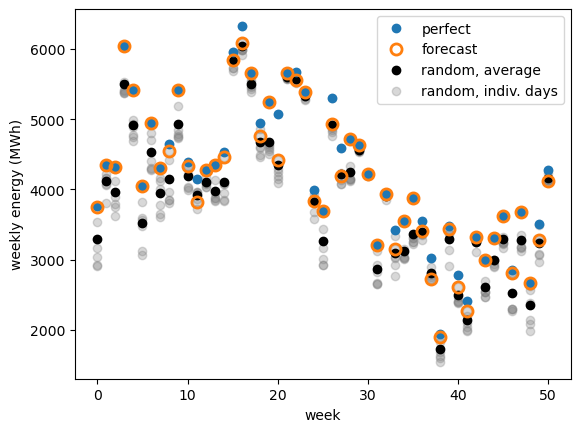

In [38]:
i = 3
# plot random first so it's in the back
plt.plot(weekly_rand[i],'o',ls='None', alpha=0.3, color='gray', label='random, indiv. days')
plt.plot(weekly_rand_avg[i],'o',ls='None', color='k', label='random, average')
plt.plot(weekly_optimal[i],'o',ls='None', label = 'perfect')
plt.plot(weekly_fcast_ifs_ens[i],'o',ms=8,fillstyle='none',markeredgewidth=2,ls='None', label = 'forecast')

plt.ylabel('weekly energy (MWh)')
plt.xlabel('week')

# custom order for legend, since random was plotted first
handles,labels = plt.gca().get_legend_handles_labels()
handles = [handles[-2], handles[-1], handles[-3], handles[0]]
labels = [labels[-2], labels[-1], labels[-3], labels[0]]
plt.legend(handles,labels)
# plt.savefig('images/weekly_energy_selection.png', dpi=400, bbox_inches='tight')
plt.show()

In [39]:
# dataframe with index of [week, point] and column of weekly_fcast_confidence, 
# weekly_rel_loss_reduction, weekly_abs_loss_reduction
df_weekly_stats = pd.concat([pd.DataFrame(weekly_fcast_confidence).stack(),
                             pd.DataFrame(weekly_rel_loss_reduction).stack(),
                             pd.DataFrame(weekly_abs_loss_reduction).stack()], axis=1)
df_weekly_stats
# df_weekly_stats.rename(columns={'0','weekly_fcast_confidence'})

0         1         2
0  1   0.48  0.450875  2.060441
   2   0.34  0.600498  2.772935
   3   0.44  0.957131  4.465429
   4   0.38  1.000000  3.655794
   6   0.36  0.116207  0.277331
...     ...       ...       ...
50 15  0.66  1.000000  5.372205
   16  0.42  0.560238  1.986675
   17  0.66  0.160961  0.744960
   18  0.56 -0.034657 -0.102861
   19  0.62  0.795909  1.225179

[867 rows x 3 columns]

In [40]:
df_weekly_stats.columns = ['weekly_fcast_confidence', 'weekly_rel_loss_reduction', 'weekly_abs_loss_reduction']
df_weekly_stats = df_weekly_stats.rename_axis(index=['week', 'point'])
df_weekly_stats

weekly_fcast_confidence  weekly_rel_loss_reduction  \
week point                                                       
0    1                         0.48                   0.450875   
     2                         0.34                   0.600498   
     3                         0.44                   0.957131   
     4                         0.38                   1.000000   
     6                         0.36                   0.116207   
...                             ...                        ...   
50   15                        0.66                   1.000000   
     16                        0.42                   0.560238   
     17                        0.66                   0.160961   
     18                        0.56                  -0.034657   
     19                        0.62                   0.795909   

            weekly_abs_loss_reduction  
week point                             
0    1                       2.060441  
     2                       2.772935  
     3                       4.465429  
     4                       3.655794  
     6                       0.277331  
...                               ...  
50   15                      5.372205  
     16                      1.986675  
     17                      0.744960  
     18                     -0.102861  
     19                      1.225179  

[867 rows x 3 columns]

Text(0.5, 0, 'Forecast "Confidence"')

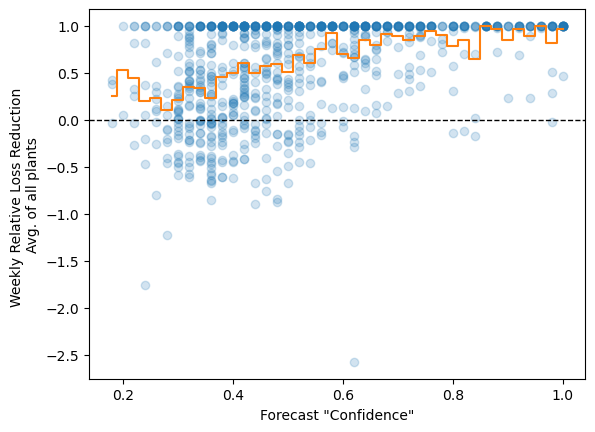

In [41]:
plt.scatter(df_weekly_stats['weekly_fcast_confidence'],
            df_weekly_stats['weekly_rel_loss_reduction'],
            alpha=0.2)
plt.plot(df_weekly_stats.groupby(['weekly_fcast_confidence']).mean().index,
         df_weekly_stats.groupby(['weekly_fcast_confidence']).mean()['weekly_rel_loss_reduction'].values,
         color='C1',
         drawstyle='steps-mid')
# plt.ylim([-1.05,1.05])
# plt.xlim([0,1])
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.ylabel('Weekly Relative Loss Reduction \nAvg. of all plants')
plt.xlabel('Forecast "Confidence"')

Text(0.5, 0, 'Forecast "Confidence"')

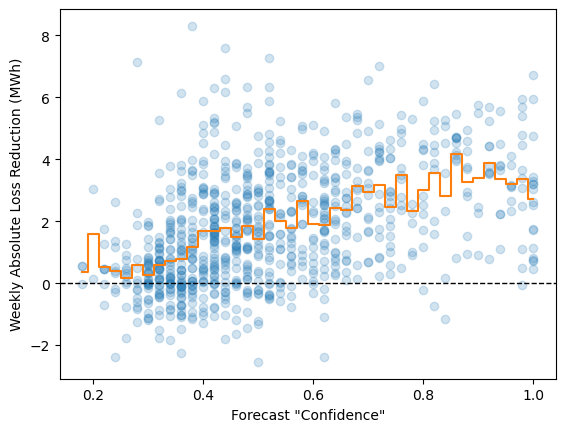

In [42]:
plt.scatter(df_weekly_stats['weekly_fcast_confidence'],
            df_weekly_stats['weekly_abs_loss_reduction'],
            alpha=0.2)
plt.plot(df_weekly_stats.groupby(['weekly_fcast_confidence']).mean().index,
         df_weekly_stats.groupby(['weekly_fcast_confidence']).mean()['weekly_abs_loss_reduction'].values,
         color='C1',
         drawstyle='steps-mid')

plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.ylabel('Weekly Absolute Loss Reduction (MWh)')
plt.xlabel('Forecast "Confidence"')

In [43]:
# import cartopy
import cartopy.crs as crs
import cartopy.feature as cfeature

In [44]:
rel_loss_reductions_ifs_ens.values()

dict_values([np.float64(0.5720642437896595), np.float64(0.7180561899026336), np.float64(0.7176234225050475), np.float64(0.605233436916722), np.float64(0.6077772355794007), np.float64(0.5951647569960326), np.float64(0.6428236635813684), np.float64(0.7180160725011124), np.float64(0.7318206817478505), np.float64(0.7424779892234482), np.float64(0.7187111443373189), np.float64(0.639321409049169), np.float64(0.7714081464914535), np.float64(0.5399665443424604), np.float64(0.7112104468563902), np.float64(0.5828445101933919), np.float64(0.5595679091639819)])

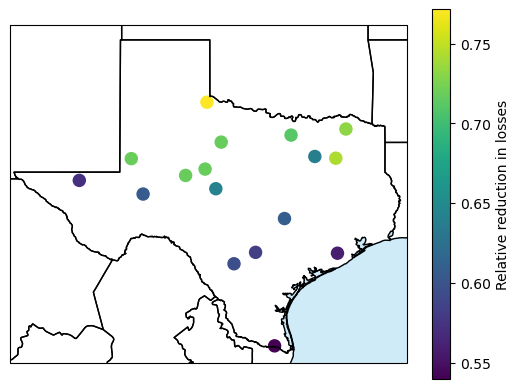

In [45]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

ax.add_feature(cfeature.OCEAN, color="skyblue", alpha=0.4)
ax.add_feature(cfeature.STATES)

ax.set_extent([-106.8, -93.3, 25.5, 37],
              crs=crs.PlateCarree()) ## Important

plt.scatter(agg_specs_orig_df.T['longitude'], agg_specs_orig_df.T['latitude'], s=75, c=rel_loss_reductions_ifs_ens.values())
plt.colorbar(label='Relative reduction in losses')
plt.show()

Let's look at the fraction of weeks where the forecast confidence is above a certain threshold for each plant:

In [46]:

thresh = 0.5
high_conf_weeks = df_weekly_stats.groupby('point')['weekly_fcast_confidence'].apply(lambda x: (x>thresh).sum()/len(x))
high_conf_weeks.values

array([0.41176471, 0.47058824, 0.45098039, 0.45098039, 0.49019608,
       0.29411765, 0.43137255, 0.43137255, 0.54901961, 0.47058824,
       0.52941176, 0.52941176, 0.54901961, 0.29411765, 0.52941176,
       0.39215686, 0.25490196])

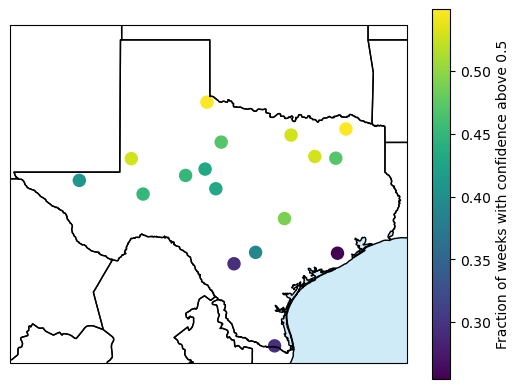

In [47]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

ax.add_feature(cfeature.OCEAN, color="skyblue", alpha=0.4)
ax.add_feature(cfeature.STATES)

ax.set_extent([-106.8, -93.3, 25.5, 37],
              crs=crs.PlateCarree()) ## Important

plt.scatter(agg_specs_orig_df.T['longitude'],
            agg_specs_orig_df.T['latitude'],
            s=75,
            c=high_conf_weeks.values)
plt.colorbar(label='Fraction of weeks with confidence above ' + str(thresh))
plt.show()